# Segmentation Prelim Experiments 

Generalized Procrustes Analysis on point clouds extracted using code from 7.27 Segmentation Experiments

## General Imports

In [33]:
import numpy as np
import os 
from scipy.linalg import orthogonal_procrustes
from scipy.spatial import procrustes

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

%matplotlib widget


## Define some utilities, paths

In [2]:
save_path = "/Users/Alex/Documents/TaylorLab/segmentation_raw/"

In [3]:
segmentation_list = [
("/Users/Alex/Downloads/IR_134/Segmentation RT 134/Segmentation RT 134.seg.nrrd", "Segmentation RT 134"),
("/Users/Alex/Downloads/IR_134/Segmentation LT 134/Segmentation LT 134.seg.nrrd", "Segmentation LT 134"),
("/Users/Alex/Downloads/IR_138/Segmentation RT 138/Segmentation RT 138.seg.nrrd", "Segmentation RT 138"),
("/Users/Alex/Downloads/IR_138/Segmentation LT 138/Segmentation LT 138.seg.nrrd", "Segmentation LT 138"),
("/Users/Alex/Downloads/IR_140/Segmentation RT 140/Segmentation RT 140.seg.nrrd", "Segmentation RT 140"),
("/Users/Alex/Downloads/IR_140/Segmentation LT 140/Segmentation LT 140.seg.nrrd", "Segmentation LT 140"),
("/Users/Alex/Downloads/IR_144/Segmentation RT 144/Segmentation RT 144.seg.nrrd", "Segmentation RT 144"),
("/Users/Alex/Downloads/IR_144/Segmentation LT 144/Segmentation LT 144.seg.nrrd", "Segmentation LT 144"),
("/Users/Alex/Downloads/IR_146/Segmentation RT 146/Segmentation RT 146.seg.nrrd", "Segmentation RT 146"),
("/Users/Alex/Downloads/IR_146/Segmentation LT 146/Segmentation LT 146.seg.nrrd", "Segmentation LT 146"),
("/Users/Alex/Downloads/IR_148/Segmentation LT 148/Segmentation LT 148.seg.nrrd", "Segmentation LT 148"),
("/Users/Alex/Downloads/IR_150/Segmentation RT 150/Segmentation RT 150.seg.nrrd", "Segmentation RT 150"),
("/Users/Alex/Downloads/IR_150/Segmentation LT 150/Segmentation LT 150.seg.nrrd", "Segmentation LT 150"),
("/Users/Alex/Downloads/IR_144\ but\ not\ actually/Segmentation RT lly/Segmentation RT 144.seg.nrrd", "Segmentation RT 147"),
("/Users/Alex/Downloads/IR_144\ but\ not\ actually/Segmentation LT 144/Segmentation LT 144.seg.nrrd", "Segmentation LT 147"),
]

### Basic baseline

In [99]:
seg_path, identifier = segmentation_list[0]

keep_id = 4

identifier = identifier.replace(" ", "")

seg_path_LT, identifier_LT = segmentation_list[1]

identifier_LT = identifier_LT.replace(" ", "")

In [100]:
point_cloud = np.load(save_path + identifier + "_" + str(keep_id) + ".npy")
point_cloud_LT = np.load(save_path + identifier_LT + "_" + str(keep_id) + ".npy")

In [101]:
print(point_cloud.shape)
print(point_cloud_LT.shape)

(151364, 3)
(97062, 3)


In [102]:
n_downsampled = 1100

<IPython.core.display.Javascript object>


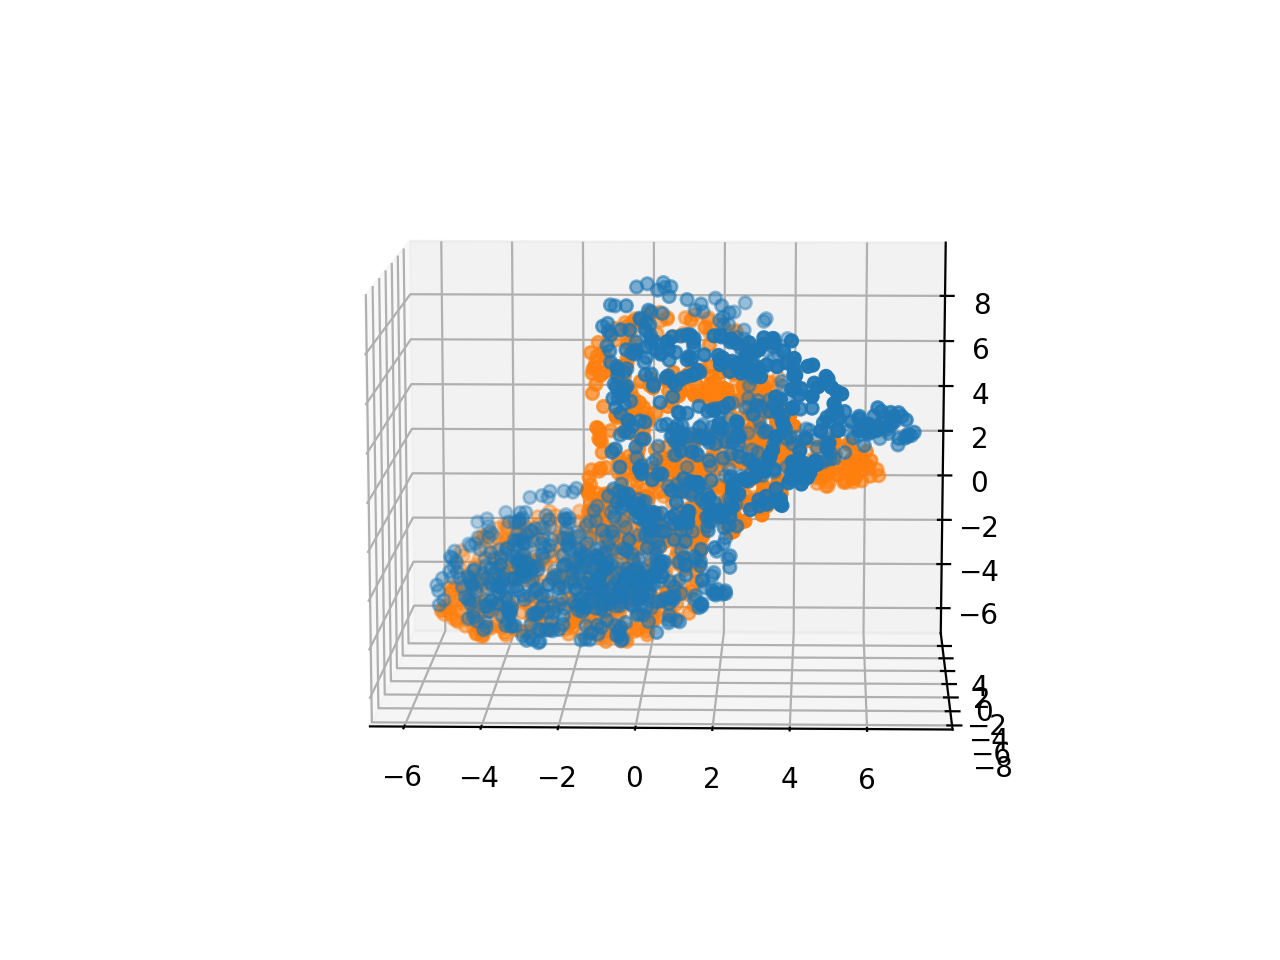

In [103]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
indices = np.random.randint(0, point_cloud.shape[0]-1, size=n_downsampled)
point_cloud = point_cloud - np.mean(point_cloud, axis=0)
ax.scatter(point_cloud[indices, 0], point_cloud[indices, 1], point_cloud[indices, 2])

indices_LT = np.random.randint(0, point_cloud_LT.shape[0]-1, size=n_downsampled)
point_cloud_LT = point_cloud_LT - np.mean(point_cloud_LT, axis=0)
point_cloud_LT[:,0] = -1.*point_cloud_LT[:, 0]
ax.scatter(point_cloud_LT[indices_LT, 0], point_cloud_LT[indices_LT, 1], point_cloud_LT[indices_LT, 2])

## Functions used in GPA 

In [9]:
def compute_mapping(initial_shape, shape):
    
    M = np.dot(shape, initial_shape.T)
    te = np.square(shape).sum(axis=1)
    tr = np.square(initial_shape).sum(axis=1)
    dists = np.sqrt(-2*M + np.matrix(tr) + np.matrix(te).T)

    return np.argmin(dists, axis=0) 

In [10]:
def correspondences(feature_array, initial_guess_id=0): 
    
    _, nfeat = feature_array.shape
    initial_guess = feature_array[initial_guess_id].reshape((nfeat/3, 3), order="F")
    
    for i, shape in enumerate(feature_array): 
        if i == initial_guess_id: 
            continue 
        shape = shape.reshape((nfeat/3, 3), order="F")
        mapping = compute_mapping(initial_guess, shape)
        feature_array[i] = shape[mapping,:].T.reshape(nfeat)
    
    
    return feature_array

### Re-implementation of procrustes that potentially does not work

In [11]:
def my_procrustes(initial_shape, shape): 
    
    mu_initial_shape = np.mean(initial_shape, axis=0)
    
    norm_initial = np.linalg.norm(initial_shape)
    norm_shape = np.linalg.norm(shape)
    
    initial_shape /= norm_initial
    shape /= norm_shape
    
    # optimum rotation matrix of Y
    A = np.dot(initial_shape.T, shape)
    U, s, Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)
    
    traceTA = s.sum()
    
#     b = 1
#     d = 1 + ssY/ssX - 2 * traceTA * normY / normX
#     Z = norm_shape*np.dot(shape, T) + mu_initial_shape
    
    Z = np.linalg.norm(initial_shape)*traceTA*np.dot(shape, T) + mu_initial_shape
    return Z 

In [109]:
def procrustes_loop(X, tol=.01, initial_guess_id=0, n_iter = 40, return_mats=True): 

    print("procrustes function")
    nshape, nfeat = X.shape
    initial_shape = X[initial_guess_id].reshape((nfeat/3, 3), order="F")

#     aligned = np.zeros(X.shape)

    transformations = {i:[] for i in range(nshape)}
    
    # procrustes loop
    for iteration in range(n_iter): 
        print("procrustes iter: ", iteration)
    
        X = correspondences(X)

        #  alignment to mean shape or initial guess
        max_disparity = 0.0
        
        for i, shape in enumerate(X):
            
             # skip the first iteration, first shape because that's our initial guess for the mean
            if iteration == 0 and i == initial_guess_id: 
                transformations[initial_guess_id].append(np.eye(3))
                continue 
                
            shape = shape.reshape((nfeat/3, 3), order="F")
            
            if iteration == 0 and i != initial_guess_id: 
                disparity = np.sum(np.square(shape - initial_shape))
                print "baseline disp for shape %d"%(i + 1), disparity
            
            R, s = orthogonal_procrustes(shape, initial_shape)
            shape = shape.dot(R) 
            
            transformations[i].append(R)
        
            disparity = np.sum(np.square(shape - initial_shape))
            
            if disparity > max_disparity:
                max_disparity = disparity
                
            print "inner disp:", disparity
            
            X[i] = np.transpose(shape).reshape(nfeat)
            
        # (re)compute the mean shape
        mean_shape = np.mean(X.reshape((nshape, nfeat/3, 3), order='F'), axis=0)
        mean_shape, initial_shape, disparity = procrustes(mean_shape, initial_shape)
        R_mean, scale_mean = orthogonal_procrustes(initial_shape, mean_shape)
    
        disparity = np.sum(np.square(initial_shape - mean_shape))

        # check if mean shape has changed
        if max_disparity > tol: 
            print(disparity)
            initial_shape = mean_shape

        else:
            print(disparity)
            break

    if return_mats: 
        return X, transformations
    
    return X

## Unaligned View

<IPython.core.display.Javascript object>


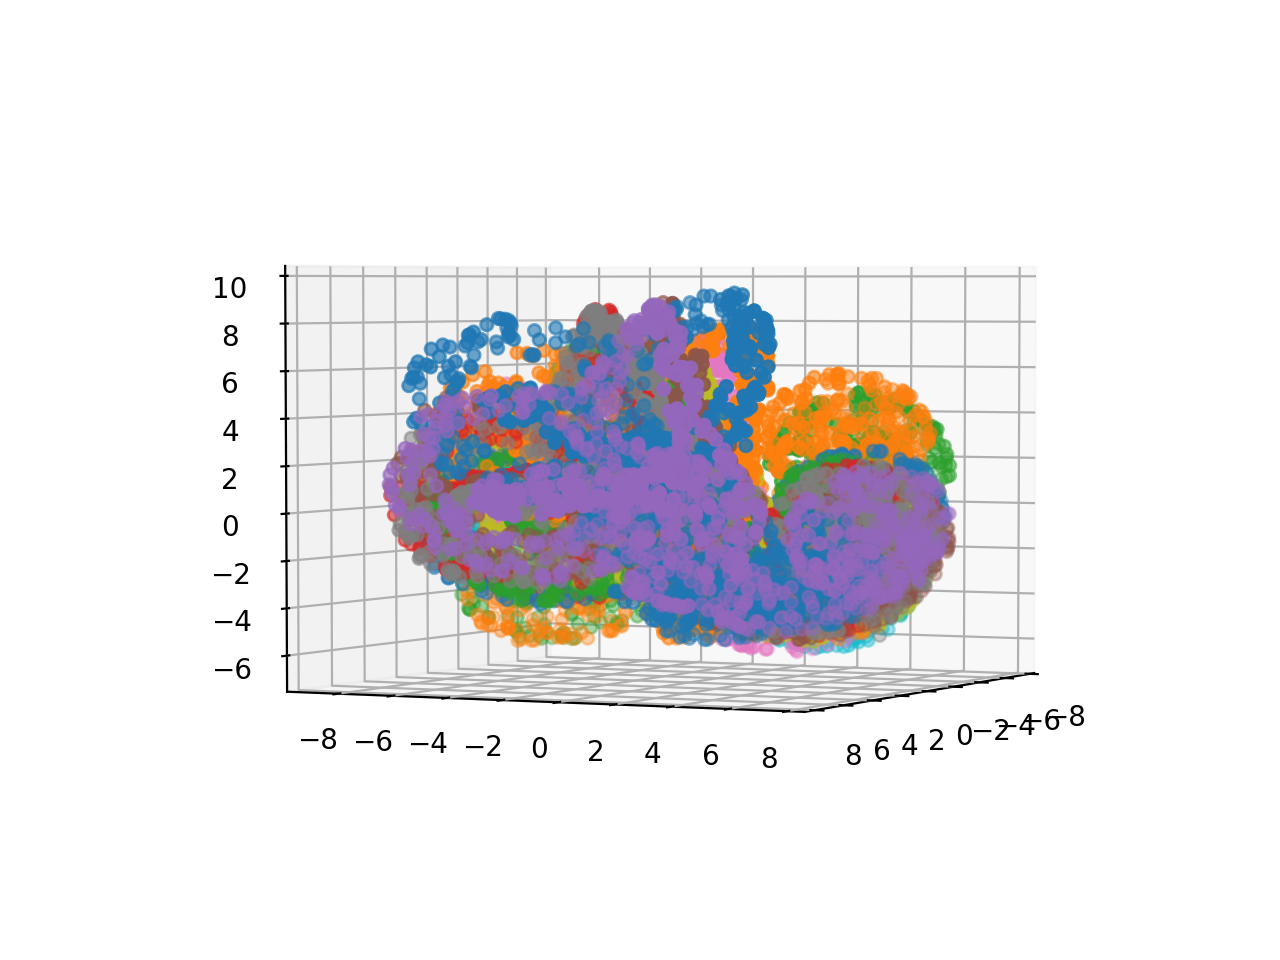

In [105]:
bigboy = []
n_downsampled = 1100
np.random.seed(2020)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for seg_path, identifier in segmentation_list[:-1]:
    keep_id = 4
    identifier = identifier.replace(" ", "")
    
    point_cloud = np.load(save_path + identifier + "_" + str(keep_id) + ".npy")
    indices = np.random.randint(0, point_cloud.shape[0]-1, size=n_downsampled)
    point_cloud = point_cloud - np.mean(point_cloud, axis=0)
    if "LT" in identifier: 
        point_cloud[:,0] = -1.*point_cloud[:,0]
    
    point_cloud = point_cloud[indices]
    ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2])
#     nrow, ncol = point_cloud.shape
#     point_cloud = np.transpose(point_cloud).reshape(nrow*ncol)
#     point_cloud.shape
#     bigboy.append(point_cloud)



## Align shapes, view

(15, 4500)
procrustes function
('procrustes iter: ', 0)
baseline disp for shape 2 850.397
inner disp: 841.17615
baseline disp for shape 3 4533.138
inner disp: 4142.5864
baseline disp for shape 4 4690.7656
inner disp: 4184.1274
baseline disp for shape 5 2035.1694
inner disp: 1699.4368
baseline disp for shape 6 2060.6528
inner disp: 1697.4891
baseline disp for shape 7 1900.7979
inner disp: 1642.3002
baseline disp for shape 8 3614.9312
inner disp: 3036.9277
baseline disp for shape 9 3019.8477
inner disp: 2576.587
baseline disp for shape 10 3672.9385
inner disp: 3007.8123
baseline disp for shape 11 4747.6094
inner disp: 4229.379
baseline disp for shape 12 5984.997
inner disp: 5952.0186
baseline disp for shape 13 7645.5957
inner disp: 7582.037
baseline disp for shape 14 3543.9429
inner disp: 2954.785
baseline disp for shape 15 3603.8667
inner disp: 3030.6843
0.016625764088867866
('procrustes iter: ', 1)
inner disp: 51399.25758945086
inner disp: 47434.508460765355
inner disp: 42684.809163177

inner disp: 51398.00487310721
inner disp: 47385.01570525539
inner disp: 43617.18228520253
inner disp: 43157.139177950696
inner disp: 47889.28315743127
inner disp: 47963.16269828401
inner disp: 44765.079955117195
inner disp: 47258.72508180732
inner disp: 44913.33381560904
inner disp: 44931.242298556506
inner disp: 42741.48276695437
inner disp: 35081.99306942834
inner disp: 38603.04662020394
inner disp: 46900.18262744439
inner disp: 47819.624769563365
9.496737014476799e-05
('procrustes iter: ', 17)
inner disp: 51398.03643348484
inner disp: 47385.030379501324
inner disp: 43621.50398717372
inner disp: 43164.75803362933
inner disp: 47884.28183473779
inner disp: 47952.593672213814
inner disp: 44765.08756430093
inner disp: 47230.045578410325
inner disp: 44892.42059214787
inner disp: 44930.8769802349
inner disp: 42755.17951349486
inner disp: 35077.245918840534
inner disp: 38461.682901525826
inner disp: 46902.885674885605
inner disp: 47806.41783190645
8.178329058439941e-05
('procrustes iter: ',

<IPython.core.display.Javascript object>


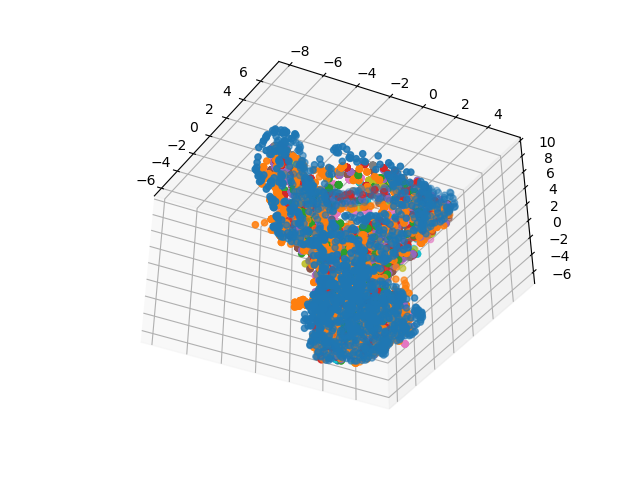

In [113]:
bigboy = []
n_downsampled = 1500
np.random.seed(2020)

for seg_path, identifier in segmentation_list:
    keep_id = 4
    identifier = identifier.replace(" ", "")
    
    point_cloud = np.load(save_path + identifier + "_" + str(keep_id) + ".npy")
    indices = np.random.randint(0, point_cloud.shape[0]-1, size=n_downsampled)
    point_cloud = point_cloud - np.mean(point_cloud, axis=0)
    if "LT" in identifier: 
        point_cloud[:,0] = -1.*point_cloud[:,0]

    point_cloud = point_cloud[indices]
    nrow, ncol = point_cloud.shape
    point_cloud = np.transpose(point_cloud).reshape(nrow*ncol)
    bigboy.append(point_cloud)

feature_array = np.array(bigboy)
print(feature_array.shape)
feature_array = correspondences(feature_array)
aligned, mats = procrustes_loop(feature_array, tol=.001, initial_guess_id=0, n_iter=20)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for shape in aligned:
    shape = shape.reshape((n_downsampled, 3), order="F")
    ax.scatter(shape[:,0], shape[:,1], shape[:,2])

## Checking if rotation matrices are close to identity 

indeed, many are. The max iterations of the generalized procrustes analysis were truncated to avoid unnecessary computation.  

In [114]:
for idx, transformations in mats.iteritems(): 
    print idx
    for j, transformation in enumerate(transformations):
        if np.allclose(np.eye(3), transformation): 
            print "yikes!", j

0
yikes! 0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


## Plotting the gradual transformations 

In [15]:
import ipyvolume as ipv

In [115]:
time_seqs = [[landmarks.reshape((n_downsampled, 3), order="F")] for landmarks in feature_array ]

for i, landmarks in enumerate(time_seqs): 
    
    for transform in mats[i]:
        next_landmark = landmarks[-1].dot(transform)
        time_seqs[i].append(next_landmark)
    
time_seqs = np.array(time_seqs)
print(time_seqs.shape) 


ipv.figure()
scatters = []
for time_seq in time_seqs: 
    s = ipv.scatter(time_seq[:,:,0], time_seq[:,:,1], time_seq[:,:,2], 
                    marker="sphere", 
                    color='rgb(%d,%d,%d)'%tuple(np.random.randint(0, 256, 3))
                   )
    scatters.append(s)

# nshape, nfeat = aligned.shape
# mean_shape = np.mean(aligned.reshape((nshape, nfeat/3, 3), order="F"), axis=0)
# s2 = ipv.scatter(mean_shape[:,0], mean_shape[:,1], mean_shape[:,2], marker="sphere", color="blue")

ipv.xyzlim(-8, 8)

ipv.animation_control(scatters)
ipv.show()
    
    

(15, 21, 1500, 3)


VkJveChjaGlsZHJlbj0oRmlndXJlKGFuaW1hdGlvbj0yMDAuMCwgY2FtZXJhPVBlcnNwZWN0aXZlQ2FtZXJhKGZvdj00Ni4wLCBwb3NpdGlvbj0oMC4wLCAwLjAsIDIuMCksIHF1YXRlcm5pb27igKY=


## Visualizing the Mean Shape

<IPython.core.display.Javascript object>


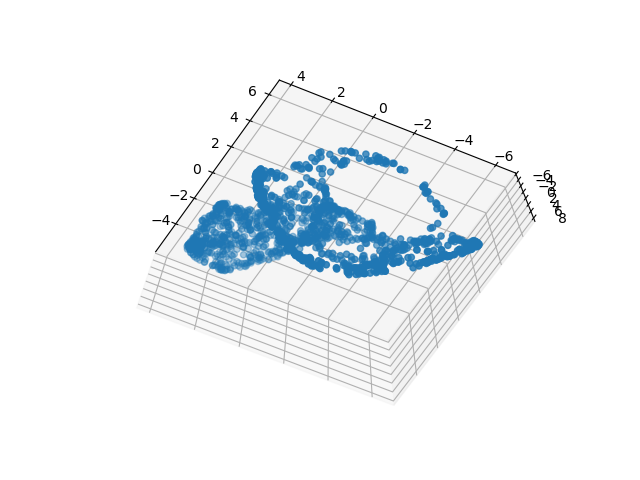

(1500, 3)


In [116]:
nshape, nfeat = aligned.shape

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

corresponded_mean_shape = np.mean(aligned.reshape((nshape, nfeat/3, 3), order="F"), axis=0)
print corresponded_mean_shape.shape
ax.scatter(corresponded_mean_shape[:,0], corresponded_mean_shape[:,1], corresponded_mean_shape[:,2])

## Principal Components Analysis

In [78]:
bigboy = []
n_downsampled = 1000
np.random.seed(2020)

for seg_path, identifier in segmentation_list[:-1]:
    keep_id = 4
    identifier = identifier.replace(" ", "")
    
    point_cloud = np.load(save_path + identifier + "_" + str(keep_id) + ".npy")
    indices = np.random.randint(0, point_cloud.shape[0]-1, size=n_downsampled)
    point_cloud = point_cloud - np.mean(point_cloud, axis=0)
    if "LT" in identifier: 
        point_cloud[:,0] = -1.*point_cloud[:,0]
    
    point_cloud = point_cloud[indices]
    nrow, ncol = point_cloud.shape
    point_cloud = np.transpose(point_cloud).reshape(nrow*ncol)
    point_cloud.shape
    bigboy.append(point_cloud)

feature_array = np.array(bigboy)
feature_array.shape
    
    
    

(14, 3000)

In [121]:
diff_from_mean = aligned.reshape((nshape, nfeat/3, 3), order="F") - corresponded_mean_shape 
diff_from_mean = diff_from_mean.reshape((nshape, nfeat), order="F")
u, s, vh = np.linalg.svd(diff_from_mean, full_matrices=False)
u.shape, s.shape, vh.shape

((15, 15), (15,), (15, 4500))

<IPython.core.display.Javascript object>


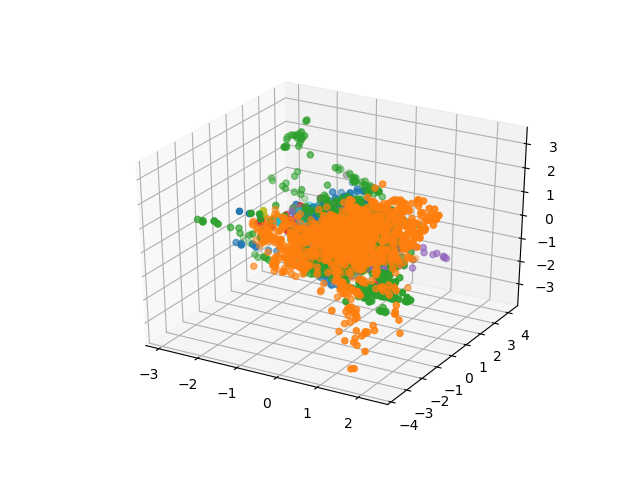

In [122]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for shape in diff_from_mean: 
    shape = shape.reshape((nfeat/3, 3), order="F")
    ax.scatter(shape[:,0], shape[:,1], shape[:,2] )

### The First Few Principal Components

<IPython.core.display.Javascript object>


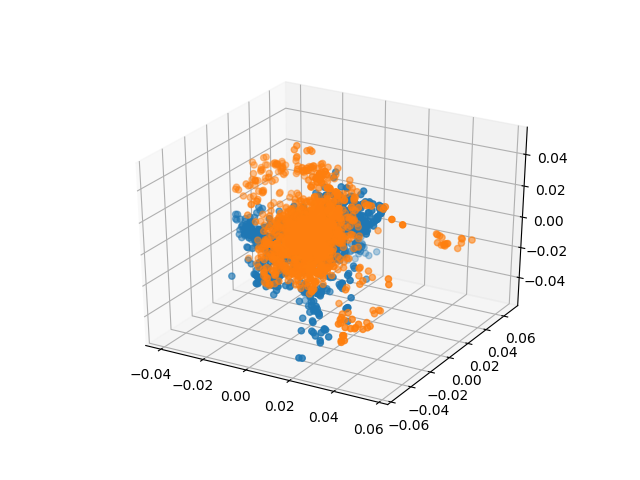

In [124]:
# vh = vh.reshape(n_downsampled, 3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for pc in vh[:2]:
    pc = pc.reshape((vh.shape[-1]/3, 3), order="F")
    ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2])

# projected = np.matmul(aligned, vh[:1,:].T)
# # projected.shape
# first_pc = vh[3].reshape((n_downsampled, 3), order="F")
# ax.scatter(first_pc[:, 0], first_pc[:, 1], first_pc[:, 2])

### Percentage Variance Explained by Each Principal Component

In [125]:
np.square(s)/np.sum(np.square(s))


array([2.8785837e-01, 2.4190521e-01, 1.0879502e-01, 7.4312180e-02,
       4.1218549e-02, 3.8575757e-02, 3.6055841e-02, 3.2074995e-02,
       2.8812211e-02, 2.6945265e-02, 2.3834454e-02, 2.0975158e-02,
       2.0246562e-02, 1.8390438e-02, 1.7971291e-13], dtype=float32)

<IPython.core.display.Javascript object>


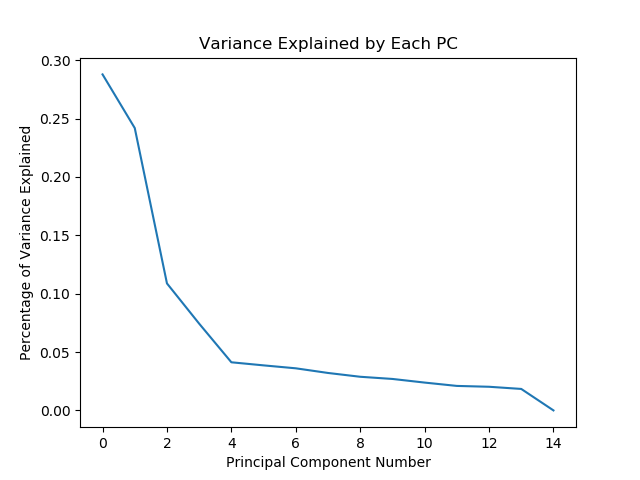

Text(0.5,1,'Variance Explained by Each PC')

In [126]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(s)), np.square(s)/np.sum(np.square(s)))
ax.set_xlabel("Principal Component Number")
ax.set_ylabel("Percentage of Variance Explained")
ax.set_title("Variance Explained by Each PC")

## Applying Rotation Matrices to Other Segments

### Load in another segment for each scan

<IPython.core.display.Javascript object>


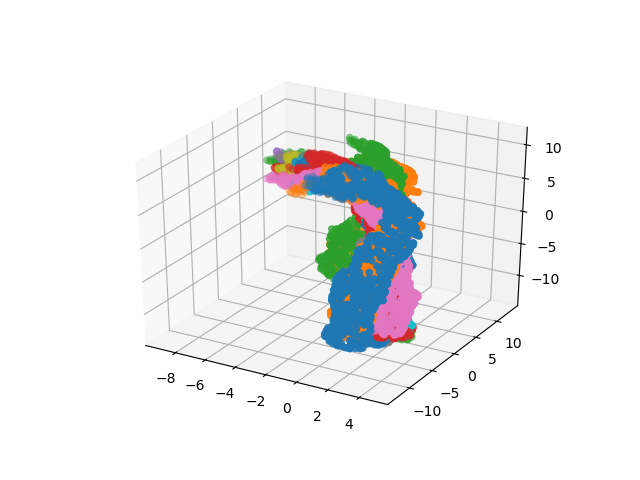

In [127]:
bigboy = []
n_downsampled = 1000
np.random.seed(2020)
keep_id = 9

for seg_path, identifier in segmentation_list[:-1]:

    identifier = identifier.replace(" ", "")
    
    point_cloud = np.load(save_path + identifier + "_" + str(keep_id) + ".npy")
    indices = np.random.randint(0, point_cloud.shape[0]-1, size=n_downsampled)
    point_cloud = point_cloud - np.mean(point_cloud, axis=0)
    if "LT" in identifier: 
        point_cloud[:,0] = -1.*point_cloud[:,0]
    
    point_cloud = point_cloud[indices]
    nrow, ncol = point_cloud.shape
    point_cloud = np.transpose(point_cloud).reshape(nrow*ncol)
    point_cloud.shape
    bigboy.append(point_cloud)

feature_array_external = np.array(bigboy)
feature_array_external.shape
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for arr in feature_array_external: 
    arr = arr.reshape((n_downsampled, 3), order="F")
    ax.scatter(arr[:, 0], arr[:, 1], arr[:, 2])
    

In [129]:
len(mats[0])

20

In [130]:
time_seqs = [[landmarks.reshape((n_downsampled, 3), order="F")] for landmarks in feature_array_external]

for i, landmarks in enumerate(time_seqs): 
    
    for transform in mats[i]:
        next_landmark = landmarks[-1].dot(transform)
        time_seqs[i].append(next_landmark)
    
time_seqs = np.array(time_seqs)
print(time_seqs.shape) 


ipv.figure()
scatters = []
for time_seq in time_seqs: 
    s = ipv.scatter(time_seq[:,:,0], time_seq[:,:,1], time_seq[:,:,2], 
                    marker="sphere", 
                    color='rgb(%d,%d,%d)'%tuple(np.random.randint(0, 256, 3))
                   )
    scatters.append(s)

# nshape, nfeat = aligned.shape
# mean_shape = np.mean(aligned.reshape((nshape, nfeat/3, 3), order="F"), axis=0)
# s2 = ipv.scatter(mean_shape[:,0], mean_shape[:,1], mean_shape[:,2], marker="sphere", color="blue")

ipv.xyzlim(-8, 8)

ipv.animation_control(scatters)
ipv.show()
    
    

(14, 21, 1000, 3)


VkJveChjaGlsZHJlbj0oRmlndXJlKGFuaW1hdGlvbj0yMDAuMCwgY2FtZXJhPVBlcnNwZWN0aXZlQ2FtZXJhKGZvdj00Ni4wLCBwb3NpdGlvbj0oMC4wLCAwLjAsIDIuMCksIHF1YXRlcm5pb27igKY=


(14, 3000)


<IPython.core.display.Javascript object>


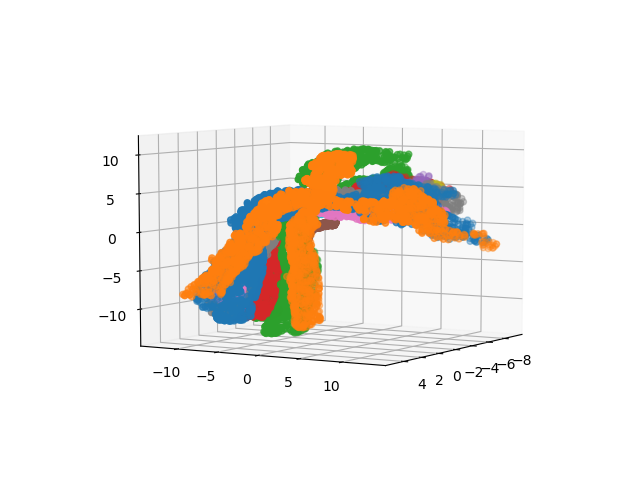

In [96]:
for i in range(len(feature_array_external)):     
    reshaped = feature_array_external[i].reshape((n_downsampled, 3), order="F")
    for transform in mats[i]:
        reshaped = reshaped.dot(transform)
    feature_array_external[i] = reshaped.T.reshape(n_downsampled*3)
    
print feature_array_external.shape
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for arr in feature_array_external: 
    arr = arr.reshape((n_downsampled, 3), order="F")
    ax.scatter(arr[:, 0], arr[:, 1], arr[:, 2])

In [94]:
plt.close('all')